In this notebook I will try and predict what kind of an incident occured based on where it took place and how long it took to resolve. 

Target: issue_reported(y)
Input vairables: Latitude, Longitude, timespan_min(x)


In [240]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import svm

In [241]:
file = 'traffic_data_features.csv'

In [242]:
df = pd.read_csv(file, index_col=False)
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month
0,Crash Service,30.283797,-97.741906,2,144.066667,6,6
1,Traffic Hazard,30.339593,-97.700963,2,64.450000,10,6
2,Crash Service,30.329455,-97.638105,4,30.000000,21,4
3,Traffic Hazard,30.202806,-97.760701,4,14.183333,21,4
4,Crash Service,30.184265,-97.687339,4,149.150000,21,4


In [243]:
df.describe()

,Latitude,Longitude,day,timespan_min,hour,month
count,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000
mean,30.301440,-97.733156,2.906261,49.665617,13.693637,6.980594
std,0.094080,0.087511,1.935056,39.684226,7.140035,3.388540
min,30.003883,-98.226709,0.000000,0.333333,0.000000,1.000000
25%,30.231715,-97.777183,1.000000,19.500000,9.000000,4.000000
50%,30.293602,-97.734450,3.000000,37.500000,15.000000,7.000000
75%,30.373691,-97.686922,5.000000,68.516667,20.000000,10.000000
max,30.798642,-97.293320,6.000000,200.000000,23.000000,12.000000


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225445 entries, 0 to 225444
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   issue_reported  225445 non-null  object 
 1   Latitude        225445 non-null  float64
 2   Longitude       225445 non-null  float64
 3   day             225445 non-null  int64  
 4   timespan_min    225445 non-null  float64
 5   hour            225445 non-null  int64  
 6   month           225445 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 12.0+ MB


In [245]:
le = LabelEncoder()
df['issue_reported']=le.fit_transform(df['issue_reported'])
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month
0,2,30.283797,-97.741906,2,144.066667,6,6
1,5,30.339593,-97.700963,2,64.450000,10,6
2,2,30.329455,-97.638105,4,30.000000,21,4
3,5,30.202806,-97.760701,4,14.183333,21,4
4,2,30.184265,-97.687339,4,149.150000,21,4


In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225445 entries, 0 to 225444
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   issue_reported  225445 non-null  int64  
 1   Latitude        225445 non-null  float64
 2   Longitude       225445 non-null  float64
 3   day             225445 non-null  int64  
 4   timespan_min    225445 non-null  float64
 5   hour            225445 non-null  int64  
 6   month           225445 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 12.0 MB


In [247]:
df['issue_reported'].unique()

array([2, 5, 1, 4, 0, 3, 6])

In [248]:
df['issue_reported'].value_counts()

5    92530
2    85024
0    25467
4    10818
3     5567
1     5286
6      753
Name: issue_reported, dtype: int64

In [249]:
avg_issue = df.groupby('issue_reported').mean()
avg_issue_span = avg_issue.timespan_min
avg_issue_span

issue_reported
0    42.979385
1    55.196339
2    68.461010
3    42.089731
4    31.433333
5    36.540976
6    45.440106
Name: timespan_min, dtype: float64

In [250]:
median_issue = df.groupby('issue_reported').median()
median_issue_span = median_issue.timespan_min
median_issue_span

issue_reported
0    36.016667
1    50.450000
2    60.466667
3    32.066667
4    22.775000
5    27.000000
6    31.833333
Name: timespan_min, dtype: float64

Location definitions
vnw = The very northwest edge of the city that is west of I35 and north of 183
vcw = West of MOPAC but south of 183 and north of 290
vsw = The very southwest edge of the city that is west of I35 and south of Ben White

cnw = Central northwest of the city, west of I35, south of 183, east of MOPAC, north of MLK
cw = Central west of the city, west of I35, south of MLK, east of MOPAC, north of the river
csw = Central southwest of the city, west of I35, south of the river, east of MOPAC, north of Ben White

cne = Central northeast of the city, east of I35, South of 183, east of 183 and north of MLK
ce = Central east of the city, east of I35, south of MLK, east of 183, north of the river
cse = Central southeast of the city, east of I35, south of the river, east of 183, north of Ben White

vne = The very northeast edge of the city that is east of I35, east and north of 183
vce = The very east of the city, east 183, south of 290(east), north of Ben White/71
vse = The very southeast of the city, east of I35, south of Ben White/71

other = a coordinate not within a field

In [251]:
def partOfCity(lat, lon):
    if (lat <= 30.21638 and lon < -97.72575):
        return "vsw"
    elif (lat <= 30.21638 and lon >= -97.72575):
        return "vse"
    
    elif (lat > 30.33926 and lon < -97.72575):
        return "vnw"
    elif (lat >= 30.33926 and lon >= -97.72575):
        return "vne"
    
    elif (lat >= 30.21638 and lat < 30.33926 and lon < -97.75816):
        return "vcw"
    elif (lat >= 30.21638 and lat <= 30.33926 and lon >= -97.66523):
        return "vce"
    #inner grid
    elif (lat < 30.25108 and lat >= 30.21638 and lon < -97.72575 and lon > -97.75816):
        return "csw"
    elif (lat < 30.25108 and lat >= 30.21638 and lon >= -97.72575 and lon < -97.66523):
        return "cse"
    
    elif (lat < 30.33926 and lat > 30.27887 and lon > -97.72575 and lon < -97.66523):
        return "cne"
    elif (lat <= 30.33926 and lat > 30.27887 and lon <= -97.72575 and lon > -97.75816):
        return "cnw"
    
    elif(lat >= 30.25108 and lat <= 30.27887 and lon >= -97.72575 and lon <= -97.66523):
        return "ce"
    elif(lat > 30.25108 and lat < 30.27887 and lon < -97.72575 and lon > -97.75816):
        return "cw"
    else:
        return "other"

I want to create a new column called "region" and use the above fuction to divide up incidents into one of 12 areas.

In [252]:
#df['region'] = partOfCity(df.Latitude,df.Longitude)


In [253]:
df['region'] = df.apply(lambda x: partOfCity(x['Latitude'], x['Longitude']), axis=1)

In [254]:
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region
0,2,30.283797,-97.741906,2,144.066667,6,6,cnw
1,5,30.339593,-97.700963,2,64.450000,10,6,vne
2,2,30.329455,-97.638105,4,30.000000,21,4,vce
3,5,30.202806,-97.760701,4,14.183333,21,4,vsw
4,2,30.184265,-97.687339,4,149.150000,21,4,vse


In [255]:
df['region'].value_counts()

vne    46522
vnw    34619
vcw    29815
vsw    28881
cne    16911
vse    13828
cw     13356
vce    13000
cnw     9623
csw     7660
cse     6366
ce      4864
Name: region, dtype: int64

In [256]:
df['region'].value_counts().sum()

225445

In [257]:
le2 = LabelEncoder()
df['region']=le2.fit_transform(df['region'])
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region
0,2,30.283797,-97.741906,2,144.066667,6,6,2
1,5,30.339593,-97.700963,2,64.450000,10,6,8
2,2,30.329455,-97.638105,4,30.000000,21,4,6
3,5,30.202806,-97.760701,4,14.183333,21,4,11
4,2,30.184265,-97.687339,4,149.150000,21,4,10


In [268]:
X = df.iloc[:, [3,4,5,6,7]]
X.head()


,day,timespan_min,hour,month,region
0,2,144.066667,6,6,2
1,2,64.450000,10,6,8
2,4,30.000000,21,4,6
3,4,14.183333,21,4,11
4,4,149.150000,21,4,10


In [269]:
y = df.iloc[:,0]
y.head()

0    2
1    5
2    2
3    5
4    2
Name: issue_reported, dtype: int64

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.40, random_state=123)

In [280]:
X_train.head()

,day,timespan_min,hour,month,region
63640,0,28.300000,6,6,1
57925,4,132.000000,15,5,9
114189,2,34.000000,22,3,5
59015,3,19.000000,15,5,9
97065,6,58.683333,23,12,11


In [281]:
scaler = StandardScaler()

In [282]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [283]:
test_scores = []
train_scores = []

for i in range(1,10):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [284]:
print(train_scores, " ", test_scores)

[0.9980852683951, 0.7128789726984409, 0.6787169080411335, 0.6474676011148321, 0.6293626679086547, 0.6138082459136375, 0.6076056983595408, 0.5990300664611472, 0.5933080500048054]   [0.422331389030584, 0.39379893100312713, 0.4464392645656369, 0.4693384195701834, 0.4779436226130542, 0.48967597418439085, 0.4969726540841447, 0.5012752556055801, 0.5082281709507862]


In [287]:
r = list(range(1,10))
r[train_scores.index(max(train_scores))]


1

In [288]:
r[test_scores.index(max(test_scores))]

9

/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


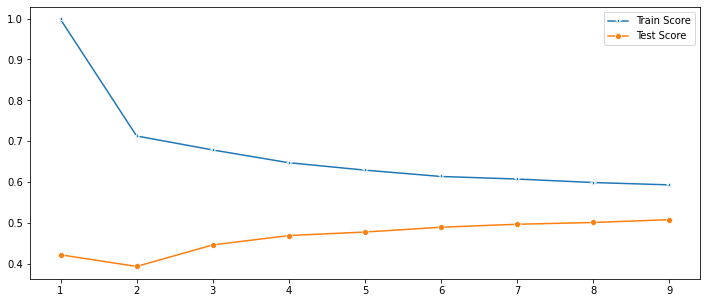

In [289]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,10),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,10),test_scores,marker='o',label='Test Score')